### Install and Load Libraries

In [1]:
# Install yfinance
!pip install yfinance

     |████████████████████████████████| 6.3 MB 5.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=dab25c4c3b3b2219369e6f5a58daa13af02a44111135c97b398d18da15534d9d
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# Install talib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3769    0  3769    0     0   3329      0 --:--:--  0:00:01 --:--:--  3326
100  503k  100  503k    0     0   176k      0  0:00:02  0:00:02 --:--:--  654k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3817    0  3817    0     0   2726      0 --:--:--  0:00:01 --:--:--  2724
100  406k  100  406k    0     0   130k      0  0:00:03  0:00:03 --:--:--  442k


In [218]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt

### Import Data

In [219]:
# Get meta data for stock VZ
vz = yf.Ticker('VZ')

In [220]:
# Get historic data from June 2021 to July 2021 with an 1-hour interval
# Save data to dataframe
df = vz.history(start='2021-06-01', end='2021-08-01', interval='1h')
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
df.drop(df[df.Volume==0].index, inplace=True)

In [296]:
df.head()

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,Close_1H,High_1H,Low_1H,Open - Open_1H,Open - Close_1H,Return,Return_1H,Return_2H,Return_3H,Return_4H,Return_5H,Return_6H,Return_7H,Return_8H,Return_9H,Signal,Signal_Pred,Return_Pred,Cum_Return_Pred,Cum_Return
2021-06-03 15:30:00-04:00,57.000000,57.064999,56.970001,56.980000,1368550,56.027166,56.885760,0.678514,56.939425,31.058790,57.000000,57.035000,56.959999,0.029999,0.000000,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,0.002740,-0.001064,-0.003085,-1,NaN,NaN,NaN,NaN
2021-06-04 09:30:00-04:00,56.919998,57.195000,56.900002,57.090000,2643686,54.978268,56.902760,0.652011,56.959999,32.219837,56.980000,57.064999,56.970001,-0.080002,-0.060001,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,0.002740,-0.001064,1,NaN,NaN,NaN,NaN
2021-06-04 10:30:00-04:00,57.090000,57.340000,57.080002,57.228699,1512084,59.600228,56.948260,0.613096,57.220001,34.248288,57.090000,57.195000,56.900002,0.170002,0.000000,0.002332,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,0.002740,1,NaN,NaN,NaN,NaN
2021-06-04 11:30:00-04:00,57.223301,57.259998,57.150002,57.180000,1023970,64.680153,57.013869,0.568215,56.900002,36.906628,57.228699,57.340000,57.080002,0.133301,-0.005398,-0.000757,0.002332,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,-1,NaN,NaN,NaN,NaN
2021-06-04 12:30:00-04:00,57.180000,57.275700,57.180000,57.240002,1127395,61.655666,57.065870,0.411722,56.900002,39.299134,57.180000,57.259998,57.150002,-0.043301,0.000000,0.000874,-0.000757,0.002332,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,1,NaN,NaN,NaN,NaN


In [221]:
# Define lookback window
n = 10

### Create Indicators

In [223]:
# Create RSI
df['RSI'] = ta.RSI(np.array(df.Close.shift(1)), timeperiod=n)

In [224]:
# Create simple moving average and correlation
df['SMA'] = df.Close.shift(1).rolling(window=n).mean()
df['Corr'] = df.Close.shift(1).rolling(window=n).corr(df.SMA.shift(1))

In [225]:
# Create SAR
df['SAR'] = ta.SAR(np.array(df.High.shift(1)),
                   np.array(df.Low.shift(1)),
                   acceleration=0.2, maximum=0.2)

In [226]:
# Create ADX
df['ADX'] = ta.ADX(np.array(df.High.shift(1)),
                   np.array(df.Low.shift(1)),
                   np.array(df.Open),
                   timeperiod=n)

In [227]:
# Create yesterday's Close, High and Low
df['Close_1H'] = df.Close.shift(1)
df['High_1H'] = df.High.shift(1)
df['Low_1H'] = df.Low.shift(1)

In [228]:
# Create difference between today's Open and yesterday's Open
df['Open - Open_1H'] = df.Open - df.Open.shift(1)
# Create difference betwwen today's Open and yesterday's Close
df['Open - Close_1H'] = df.Open - df.Close_1H

In [229]:
# Create 1 to n days returns
df['Return'] = np.log(df.Open.shift(-1) / df.Open)
for i in range(1, n):
  df['Return_%iH'%i] = df['Return'].shift(i)

In [230]:
df.head()

,Open,High,Low,Close,Volume,RSI,SMA,Corr,SAR,ADX,Close_1H,High_1H,Low_1H,Open - Open_1H,Open - Close_1H,Return,Return_1H,Return_2H,Return_3H,Return_4H,Return_5H,Return_6H,Return_7H,Return_8H,Return_9H
2021-06-01 09:30:00-04:00,56.750000,56.860001,56.540001,56.775002,3389335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 10:30:00-04:00,56.779999,56.790001,56.509998,56.534100,2117427,NaN,NaN,NaN,NaN,NaN,56.775002,56.860001,56.540001,0.029999,0.004997,-0.004413,0.000528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 11:30:00-04:00,56.529999,56.535000,56.380001,56.404999,1641920,NaN,NaN,NaN,56.860001,NaN,56.534100,56.790001,56.509998,-0.250000,-0.004101,-0.002214,-0.004413,0.000528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 12:30:00-04:00,56.404999,56.430000,56.310001,56.330002,1515329,NaN,NaN,NaN,56.790001,NaN,56.404999,56.535000,56.380001,-0.125000,0.000000,-0.001242,-0.002214,-0.004413,0.000528,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 13:30:00-04:00,56.334999,56.369900,56.270000,56.355000,1381454,NaN,NaN,NaN,56.790001,NaN,56.330002,56.430000,56.310001,-0.070000,0.004997,0.000444,-0.001242,-0.002214,-0.004413,0.000528,NaN,NaN,NaN,NaN,NaN


### Preprocess Data and Create Signals

In [231]:
# Drop nan values
df.dropna(inplace=True)

In [232]:
# Define split for training and testing
split = int(0.8 * df.shape[0])

In [233]:
# Create signals
df['Signal'] = 0
df.loc[df.Return > df.Return[:split].quantile(q=0.66), 'Signal'] = 1
df.loc[df.Return < df.Return[:split].quantile(q=0.33), 'Signal'] = -1

In [234]:
# Define features and targets
x_data = df.drop(['Close','High','Low','Volume','Return','Signal'], axis=1)
y_data = df.Signal

In [235]:
x_data.head()

,Open,RSI,SMA,Corr,SAR,ADX,Close_1H,High_1H,Low_1H,Open - Open_1H,Open - Close_1H,Return_1H,Return_2H,Return_3H,Return_4H,Return_5H,Return_6H,Return_7H,Return_8H,Return_9H
2021-06-03 15:30:00-04:00,57.000000,56.027166,56.885760,0.678514,56.939425,31.058790,57.000000,57.035000,56.959999,0.029999,0.000000,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,0.002740,-0.001064,-0.003085
2021-06-04 09:30:00-04:00,56.919998,54.978268,56.902760,0.652011,56.959999,32.219837,56.980000,57.064999,56.970001,-0.080002,-0.060001,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,0.002740,-0.001064
2021-06-04 10:30:00-04:00,57.090000,59.600228,56.948260,0.613096,57.220001,34.248288,57.090000,57.195000,56.900002,0.170002,0.000000,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816,0.002740
2021-06-04 11:30:00-04:00,57.223301,64.680153,57.013869,0.568215,56.900002,36.906628,57.228699,57.340000,57.080002,0.133301,-0.005398,0.002332,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259,0.002816
2021-06-04 12:30:00-04:00,57.180000,61.655666,57.065870,0.411722,56.900002,39.299134,57.180000,57.259998,57.150002,-0.043301,0.000000,-0.000757,0.002332,0.002982,-0.001405,0.000526,-0.002104,0.000718,-0.002468,0.005259


In [236]:
y_data.head()

2021-06-03 15:30:00-04:00   -1
2021-06-04 09:30:00-04:00    1
2021-06-04 10:30:00-04:00    1
2021-06-04 11:30:00-04:00   -1
2021-06-04 12:30:00-04:00    1
Name: Signal, dtype: int64

Text(0, 0.5, 'RSI')

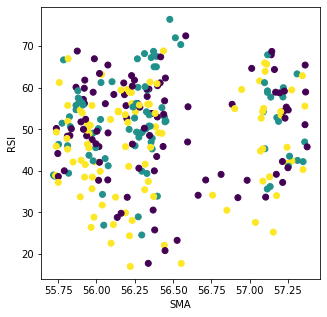

In [238]:
# Scatter plot of SMA and RSI
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x_data[['SMA','RSI']].values[:,0],
            x_data[['SMA','RSI']].values[:,1],
            c=y_data.values)
plt.xlabel('SMA')
plt.ylabel('RSI')

Text(0, 0.5, 'SAR')

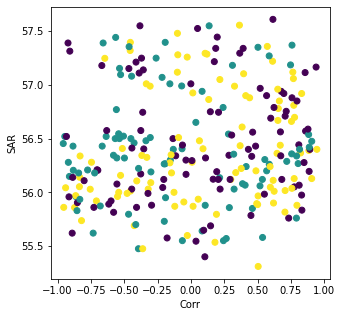

In [239]:
# Scatter plot of Corr and SAR
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x_data[['Corr','SAR']].values[:,0],
            x_data[['Corr','SAR']].values[:,1],
            c=y_data.values)
plt.xlabel('Corr')
plt.ylabel('SAR')

### Model Training

In [241]:
# Load libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [242]:
# Create pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [243]:
# Define split for time series
tscv = TimeSeriesSplit(n_splits=5)

In [244]:
# Hyperparameters for randomized search
C_rs = np.linspace(10, 10000, num=40)
gamma_rs = np.linspace(0.01, 1, num=30)
degree = np.linspace(2, 9, num=8).astype(int)

parameters_rs = {'svc__kernel': ['rbf', 'poly'],
                 'svc__degree': degree,
                 'svc__C': C_rs,
                 'svc__gamma': gamma_rs}

In [273]:
# Define randomized search model
rsmodel = RandomizedSearchCV(pipeline, param_distributions=parameters_rs, cv=tscv, random_state=42)

In [275]:
# Fit model on training set
rsmodel.fit(x_data.iloc[:split], y_data.iloc[:split])

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('svc',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  p

In [277]:
# Find best parameters
rsmodel.best_params_

{'svc__C': 3339.9999999999995,
 'svc__degree': 2,
 'svc__gamma': 0.41965517241379313,
 'svc__kernel': 'poly'}

### Create Prediction

In [279]:
# Predict from training set
y_pred = rsmodel.predict(x_data.iloc[split:])

In [280]:
# Add predicted signal to dataframe
df['Signal_Pred'] = 0
df.iloc[:split, df.columns.get_loc('Signal_Pred')] = pd.Series(rsmodel.predict(x_data.iloc[:split]).tolist())
df.iloc[split:, df.columns.get_loc('Signal_Pred')] = y_pred

### Evaluate Prediction Performance

In [281]:
# Show result
print(classification_report(df['Signal'].iloc[split:], y_pred))

              precision    recall  f1-score   support

          -1       0.52      0.62      0.57        21
           0       0.00      0.00      0.00        15
           1       0.33      0.40      0.36        20

    accuracy                           0.38        56
   macro avg       0.28      0.34      0.31        56
weighted avg       0.31      0.38      0.34        56



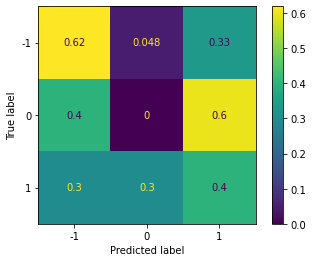

In [282]:
# Plot confusion matrix
plot_confusion_matrix(rsmodel, x_data.iloc[split:],
                      df['Signal'].iloc[split:],
                      normalize='true')

In [283]:
# Predict returns
df['Return_Pred'] = df.Return * df.Signal_Pred

In [284]:
# Calculate predicted cumulative returns
df['Cum_Return_Pred'] = 0.
df['Cum_Return_Pred'] = np.cumsum(df.Return_Pred.iloc[split:])

In [285]:
# Calcualte market cumulative returns
df['Cum_Return'] = 0.
df['Cum_Return'] = np.cumsum(df.Return.iloc[split:])

In [286]:
# Calculate Sharpe ratio
std = np.std(df.Cum_Return_Pred)
sharpe = (df.Cum_Return_Pred.iloc[-1]-df.Cum_Return.iloc[-1])/std
print('Sharpe Ratio:', sharpe)

Sharpe Ratio: 6.382963962835444


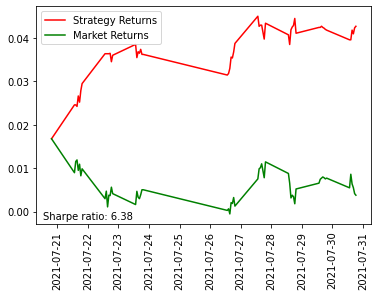

In [301]:
# Plot performance of trading strategy
plt.plot(df.Cum_Return_Pred, color='r', label='Strategy Returns')
plt.plot(df.Cum_Return, color='g', label='Market Returns')
plt.figtext(0.14, 0.14, s='Sharpe ratio: %.2f' % sharpe)
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()